# One dimensional heat equation


## Introduction

For convenience, we start by importing some modules needed below:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('../styles/mainstyle.use')

In the first notebooks of this chapter, we have described several methods to numerically solve the first order wave equation. We showed that the stability of the algorithms depends on the combination of the time advancement method and the spatial discretization.

Here we treat another case, the one dimensional heat equation:

```{math}
:label: eq:1Dheat
   \partial_t T(x,t) = \alpha \frac{d^2 T} {dx^2}(x,t) + \sigma (x,t).
```

where $T$ is the temperature and $\sigma$ is an optional heat source term.

Besides discussing the stability of the algorithms used, we will also dig deeper into the accuracy of our solutions. Up to now we have discussed accuracy from the theoretical point of view and checked that the numerical solutions computed were in qualitative agreement with exact solutions. But this is not enough, we have to quantitatively validate our solutions and check their quality. Several ways to do this are described below.

## Explicit resolution of the 1D heat equation

### Matrix stability analysis

We begin by considering the forward Euler time advancement scheme in combination with the second-order accurate centered finite difference formula for $d^2T/dx^2$. Without the source term, the algorithm then reads:

```{math}
:label: heatEulerForward
& \frac{T^{n+1}_i - T^n_i}{\Delta t}=\alpha \frac{T^n_{i-1}-2T^n_i+T^{n}_{i+1}}{\Delta x^2} \\
&\Leftrightarrow
T^{n+1}_i = T^n_i+\frac{\alpha \Delta t}{\Delta x^2} (T^n_{i-1}-2T^n_i+T^{n}_{i+1})
```

In matrix notation this is equivalent to:

```{math}
:label: eq:matHeatEuler
    \boldsymbol{T}^{n+1} = (I+A)\boldsymbol{T}^{n}\; \; \Leftrightarrow \; \; \boldsymbol{T}^{n} = (I+A)^{n}\boldsymbol{T}^{0},
```

where $I$ is the identity matrix.

Consider the case with homogeneous Dirichlet boundary conditions: $T_0^m = T_{nx-1}^m=0, \forall m$. This means that our unknowns are $T^m_1,\ldots,T^m_{nx-2}$ and that the matrix $A$ has dimensions $(nx-2)\times (nx-2)$. Its expression is:

```{math}
A = \frac{\alpha \Delta t}{\Delta x^2}
\begin{pmatrix}
a & b & 0 & 0 & 0 & \dots & 0 & 0 & 0 & 0\\
c & a & b & 0 & 0 & \dots & 0 & 0 & 0 & 0 \\
0 & c & a & b & 0 & \dots & 0 & 0 & 0 & 0 \\
0 & \dots & \dots & \dots & \dots & \dots & \dots & \dots & \dots & 0 \\
0 & \dots & \dots & \dots & \dots & \dots & \dots & \dots & \dots & 0 \\
0 & 0 & 0 & 0  & \dots & c & a & b & 0 & 0 \\
0 & 0 & 0 & 0 & \dots & 0 & c & a & b & 0 \\
0 & 0 & 0 & 0 & \dots & 0 & 0 & c & a & b \\
0 & 0 & 0 & 0 & \dots & 0 & 0 & 0 & c & b
\end{pmatrix},
```

with $a = -2$ and $b = c = 1$. According to the theorem we quoted in the previous notebook concerning Toeplitz matrices, the eigenvalues $m_k$ of $A$ are in this case real and negative:

```{math}
m_k = 2\frac{\alpha \Delta t}{\Delta x^2}\left(\cos\left(\frac{\pi k}{nx-1}\right)-1\right),\; k=1,\ldots, nx-2.
```

All the eigenvalues are distinct and as a consequence, the matrix $I+A$ is diagonalizable with eigenvalues $\lambda_k = 1+m_k$. The algorithm is stable if all these eigenvalues satisfy $\vert \lambda_k \vert \leq 1$ or in other words, if all the eigenvalues of $A$ are within the stability domain of the Euler method. This imposes the following constraint on $\Delta t$:

```{math}
\Delta t\leq \frac{\Delta x^2}{2\alpha} \Leftrightarrow  F\leq 0.5
```

where $F= \alpha \Delta t/\Delta x^2$ is sometimes referred to as the Fourier number. This condition is quite strict as the limitation on the time step is proportional to $\Delta x^2$.  Explicit integration of the heat equation can therefore become problematic and implicit methods might be preferred if a high spatial resolution is needed.

If we use the RK4 method instead of the Euler method for the time discretization, eq. {eq}`eq:matHeatEuler` becomes,

```{math}
:label: eq:matHeatRK4
   \boldsymbol{T}^{n} = \left(I+A+\frac12 A^2 + \frac16 A^3+\frac{1}{24}A^4\right)^{n}\boldsymbol{T}^{0}.
```

and the algorithm is stable if all the eigenvalues $m_k$ of $A$ are contained in the stability region of the RK4 time integration scheme. The constraint on the time step is then,

```{math}
\Delta t\leq 2.79\frac{\Delta x^2}{4\alpha} \Leftrightarrow  F\leq 0.7
```

This is a little bit less restrictive than the criteria for the forward Euler method.

### Modified wavenumber analysis

We can also consider the stability of the algorithms when using periodic boundary conditions. In that case we may use the modified wavenumber analysis that we discussed in the previous notebook.

The temperature field is decomposed into Fourier modes:

```{math}
    T(x,t)=\sum_{m} \hat{T}(k_m,t) e^{ik_m x},\; \; k_m = \frac{2\pi m}{L}
```

If we substitute this expression in the heat equation (without source term) we get:

```{math}
:label: eq:FourierT
    \frac{d\hat T(k_m,t)}{dt}=-\alpha k_m^2 \hat{T}(k_m,t)
```

This equation is 'exact'. When discretizing the second-order derivative using the second-order accurate centered finite difference formula, we get instead:

```{math}
    \frac{d\hat T(k_m,t)}{dt}&=\alpha\left(\frac{e^{-ik_m \Delta x} - 2 + e^{ik_m \Delta x}}{\Delta x^2}\right) \hat{T}(k_m,t) \\
    &= -\alpha k_m'^2 \hat T(k_m,t)
```

with the modified wavenumbers being real and defined by,

```{math}
k_m'^2 = \frac{2}{\Delta x^2}(1 - \cos(k_m \Delta x)).
```

The semi-discretized equation is identical to the original equation {eq}`eq:FourierT` except for the modification of the wavenumber.

In this formulation, all the Fourier modes are decoupled and evolve according to:

```{math}
    \frac{d\hat T(k_m,t)}{dt}=\lambda \hat{T}(k_m,t),\; \; \lambda = -\alpha k'^2_m
```

Depending on how we discretize the time derivative we get different constraints on $dt$ for stability: in each case, all the coefficients $\lambda_m$ must lie within the stability domain of the corresponding scheme.

For the forward Euler method we get:

```{math}
-2 \leq -\alpha \Delta t \frac{2}{\Delta x^2}(1 - \cos(k_m \Delta x)) \leq 0
```

To ensure that these constraints are satisfied for all values of $m$, the following restriction on the time step is required:

```{math}
\Delta t \leq \frac{\Delta x^2}{2\alpha}\; \; \; \hbox{(Forward Euler mehod)}
```

For the RK4 time integration method we get:

```{math}
\Delta t \leq 2.79\frac{\Delta x^2}{4\alpha}\; \; \; \hbox{(RK4 mehod)}
```

These conditions are identical to the ones we obtained using the matrix stability method. Keep in mind that the boundary conditions are different and in general there is no guarantee that the conditions for stability will match. 

### Numerical solution

Let's implement the algorithm {eq}`heatEulerForward` and empirically check the above stability criteria. To make the problem more interesting, we include a source term in the equation by setting: $\sigma = 2\sin(\pi x)$. As initial condition we choose $T_0(x) = \sin(2\pi x)$. In that case, the exact solution of the equation reads,

```{math}
:label: eq:solution1DHeat
T(x,t)=e^{-4\pi^2\alpha t}\sin(2\pi x) + \frac{2}{\pi^2\alpha}(1-e^{-\pi^2\alpha t})\sin(\pi x).
```

To get started we import the `euler_step` function from the `steppers` module (see notebook 04_01_Advection for further details):

In [2]:
import sys
sys.path.insert(0, '../modules')
from steppers import euler_step

The heat equation is solved using the following parameters. Note that we have set $F=0.49$.

In [3]:
# Physical parameters
alpha = 0.1                     # Heat transfer coefficient
lx = 1.                         # Size of computational domain

# Grid parameters
nx = 21                         # number of grid points 
dx = lx / (nx-1)                # grid spacing
x = np.linspace(0., lx, nx)     # coordinates of grid points

# Time parameters
ti = 0.                         # initial time
tf = 5.                         # final time
fourier = 0.49                  # Fourier number
dt = fourier*dx**2/alpha        # time step
nt = int((tf-ti) / dt)          # number of time steps

# Initial condition
T0 = np.sin(2*np.pi*x)          # initial condition
source = 2*np.sin(np.pi*x)      # heat source term

In the function below we discretize the right-hand side of the heat equation using the centered finite difference formula of second-order accuracy:

In [4]:
def rhs_centered(T, dx, alpha, source):
    """Returns the right-hand side of the 1D heat
    equation based on centered finite differences
    
    Parameters
    ----------
    T : array of floats
        solution at the current time-step.
    dx : float
        grid spacing
    alpha : float
        heat conductivity
    source : array of floats
        source term for the heat equation
    
    Returns
    -------
    f : array of floats
        right-hand side of the heat equation with
        Dirichlet boundary conditions implemented
    """
    nx = T.shape[0]
    f = np.empty(nx)
    
    f[1:-1] = alpha/dx**2 * (T[:-2] - 2*T[1:-1] + T[2:]) + source[1:-1]
    f[0] = 0.
    f[-1] = 0.
    
    return f

We also define a function that returns the exact solution at any time $t$:

In [5]:
def exact_solution(x,t, alpha):
    """Returns the exact solution of the 1D
    heat equation with heat source term sin(np.pi*x)
    and initial condition sin(2*np.pi*x)
    
    Parameters
    ----------
    x : array of floats
        grid points coordinates
    t: float
        time
    
    Returns
    -------
    f : array of floats
        exact solution
    """
    # Note the 'Pythonic' way to break the long line. You could
    # split a long line using a backlash (\) but the conventional
    # way is to embrace your code in parenthesis.
    #
    # For more info we refer you to PEP8:
    # https://www.python.org/dev/peps/pep-0008/#id19 
    f = (np.exp(-4*np.pi**2*alpha*t) * np.sin(2*np.pi*x)
      + 2.0*(1-np.exp(-np.pi**2*alpha*t)) * np.sin(np.pi*x) 
      / (np.pi**2*alpha))
    
    return f

And now we perform the time stepping:

In [6]:
T = np.empty((nt+1, nx))
T[0] = T0.copy()

for i in range(nt):
    T[i+1] = euler_step(T[i], rhs_centered, dt, dx, alpha, source)

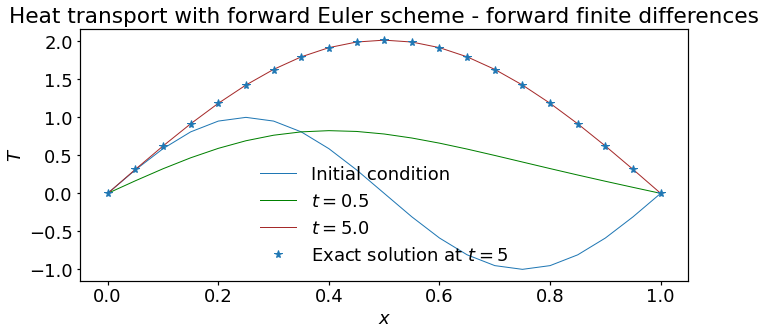

In [7]:
# plot the solution at several times
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, T[0], label='Initial condition')
ax.plot(x, T[int(0.5/dt)], color='green', label='$t=0.5$')
ax.plot(x, T[-1], color='brown', label=f'$t={tf}$')
ax.plot(x, exact_solution(x, 5.0, alpha), '*', label='Exact solution at $t=5$')


ax.set_xlabel('$x$')
ax.set_ylabel('$T$')
ax.set_title('Heat transport with forward Euler scheme'
             ' - forward finite differences')
ax.legend();

The solution looks qualitatively very good!

Run the code again with a slightly larger Fourier number equal to $0.53$ and see what happens... The solution blows up and it is clear that the stability criteria needs to be satisfied to get a stable solution.

At the beginning of this notebook we emphasized that we need better ways of checking the accuracy of our numerical solutions. To that end, let us create a function that returns the $L_2$-norm of the difference between two functions:

In [8]:
def l2_diff(f1, f2):
    """
    Computes the l2-norm of the difference
    between a function f1 and a function f2
    
    Parameters
    ----------
    f1 : array of floats
        function 1
    f2 : array of floats
        function 2
    
    Returns
    -------
    diff : float
        The l2-norm of the difference.
    """
    l2_diff = np.sqrt(np.sum((f1 - f2)**2))/f1.shape[0]
    
    return l2_diff

Using this function we can compute the relative error - in $L_2$-norm - of our computed solution compared to the exact solution:

In [9]:
error = l2_diff(T[-1], exact_solution(x, tf, alpha)) 
print(f'The L2-error made in the computed solution is {error}')

The L2-error made in the computed solution is 0.0006625553699606054


This is already quite good: in terms of the $L_2$ norm, the error is quite small. There are two ways to improve this:

1. Increase the number of grid points
2. Decrease the time step

Before we explore these possibilities, we provide a short tutorial on how to control the flow of Python loops and also introduce the `while` loop. These notions are very useful to make our codes more flexible and in particular control the convergence of our numerical solutions.

## Python loops

### *for* and *while* loops

You are already well familiar with Python `for` loops. They are also called **definite loops** meaning that the number of iterations is known before entering the loop. `for` loops are useful when you need to iterate over a certain sequence, or, sticking to Python terminology, over a *collection*. There are generally [three concepts for `for` loops][1] in programming. The one that Python implements is called *Collection-Based loop*. Schematically the Collection-Based `for` loop in Python has the following syntax:

```python
for <element> in <collection>:
    <do something>
```

`<collection>` must be *iterable*, or in other words it must be a sequence. For example you obviously cannot iterate over an integer or a function. The following code will raise Exceptions of type TypeError:

```python
for i in 785:
    print(i)

---------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-15-dec972479acc> in <module>
----> 1 for i in 784:
      2     print(i)

TypeError: 'int' object is not iterable
   
```

```python
for i in len:
    print(i)
    
---------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-17-28a55301f0c9> in <module>
----> 1 for i in len:
      2     print(i)

TypeError: 'builtin_function_or_method' object is not iterable
```

[1]: <https://realpython.com/python-for-loop/#a-survey-of-definite-iteration-in-programming> "Concepts of for loops"

But what if we do *not* know the number of iterations we need to perform in advance? Imagine we have a `list` of $10000$ elements that are integers from $0$ to $9999$. Each integer only occurs once in the sequence but its location is *random*. We are determined to compute the index (location in the sequence) of the element that is equal to $7$. First, let's implement this sequence, so that we can think of the routes we could take to solve our little problem.

In [10]:
# This variable will store our solution - index of
# the element that is equal to 7. We initially set
# it -1 and change this value only if 7 is found 
# somewhere in the sequence (which should be the case
# in our example)
ind_of_seven = -1

seq = np.linspace(0, 9999, 10000)

Right now our sequence is of course ordered. We can shuffle it using [Python's `random` module][2]:

[2]: <https://docs.python.org/3/library/random.html> "random module"

In [11]:
import random

random.shuffle(seq)

Note that `random.shuffle` returns the `None` object. It basically takes advantage of that mutable (modifiable) objects, when passed as functions arguments, are passed by object reference in Python. Or in other words, the *function does not receive a copy of an object but its address in memory*, and so it can modify or *mutate* the original object. And a numpy array is a mutable (modifiable) object.

But let's go back to our task. How are we going to approach it? In principle, we could use the `for` loop:

In [12]:
# The enumerate built-in function will manage elements'
# indices for you. At each iteration it will return the
# index of the current element and the element itself.
# That's why we need two iteration variables instead of
# usual one.
#
# For more info:
# https://docs.python.org/3/library/functions.html#enumerate
for i, elem in enumerate(seq):
    if elem == 7:
        ind_of_seven = i
        
if ind_of_seven >= 0:
    print(f'Location of 7 in the sequence: {ind_of_seven}')
else:
    # Obviously this scenario should never happen.
    print('Could not found 7 in the sequence')

Location of 7 in the sequence: 6419


We solved the problem but is our solution efficient or elegant? No. $7$ can end up being located at `i=9999` but the odds are obviously quite low. It means that most probably we are going to perform unnecessary iterations. It can be $5$ unnecessary iteration but it can as well be $9995$. **That is why there are `while` loops**. `while` loops are also called **indefinite loops**. They execute until a certain condition is satisfied. Schematically their syntax is the following:

```python
while <condition>:
    <do things>
```

The loop will execute until `<condition>` evaluates to `False`. A straightforward way to exit a `while` loop is to modify `<condition>` inside the loop. It is also worth mentioning that the code snippet


```python
while True:
    <do things>
```

implements the *infinite loop*. Normally infinite loop executes until you exceed memory limits.

Let's approach our model problem with the `while` loop:

In [13]:
# Reset solution
ind_of_seven = -1

i = 0            # current index of element in sequence
found = False    # will evaluate to True when 7 is found
while not found:
    if seq[i] == 7:
        ind_of_seven = i
        found = True
    # Increment i to proceed to the next element of seq
    i += 1
    
    
if ind_of_seven >= 0:
    print(f'Location of 7 in the sequence: {ind_of_seven}')
else:
    # Obviously this scenario should never happen.
    print('Could not found 7 in the sequence')

Location of 7 in the sequence: 6419


Such solution is obviously the preferred one for our particular problem: *we performed exactly as many iterations as we needed*.

To conclude this subsection we propose you to keep this philosophy in mind:
- Use `for` loops if you know *exactly* the number of iterations you have to perform.
- Use `while` loops if you don't know the number of iterations in advance but you know what is the condition for the loop to terminate.

You might wonder if there is another way to exit a loop before reaching the end of the sequence (in the case of the `for` loop), or to satisfy a certain condition? What if you are running your code on a supercomputer where you have requested just one hour of computation time, you are out of time and your code is still running? Or what if you perform series of computations at each iteration, end up with a singularity in the beginning of an iteration, and want to immediately proceed to the next iteration to avoid a division by zero? There are tools in Python to cover such cases, and they are the `break` and `continue` statements.

### *break* and *continue* statements

`break` and `continue` provide the possibility to terminate iterations *before* the entire body of the loop is executed.
- `break` immediately terminates execution of the loop.
- `continue` immediately terminates execution of the current iteration.

The following little examples demonstrate the distinction between `break` and `continue`:

In [14]:
# Loop is terminated if i == 5: mind the output
#
# Note the optional argument of print - end. You can configure
# what your output ends with - by default its '\n' (new line).
print('Using break statement: ', end='')
for i in range(10):
    if i == 5: break
    print(i, end=' ')

# Iteration is terminated if i == 5: mind the output
print('\nUsing continue statement: ', end='')
for i in range(10):
    if i == 5: continue
    print(i, end=' ')

Using break statement: 0 1 2 3 4 
Using continue statement: 0 1 2 3 4 6 7 8 9 

How would we approach more "real life" problems - for instance the ones assumed in the end of the previous subsection? Obviously the problem of the time limit excess is to be addressed using the `break` statement. Consider the following code snippet:

```python
# For safety we want to terminate in 55 minutes from now.
timeout = time.time() + 55*60

while True: # in principle infinite loop
    <do things>  
    # If the time limit has been reached, save data that has been computed
    # to the files and terminate loop immediately.
    if time.time() >= timeout:
        <save data to the files>
        break
```

This is the schematic example of how we would safely manage limited time resources. We have not only "gracefully" terminated our code but saved all the data we have collected to disk, so that it's not lost if we couldn't complete all of the iterations.

Consider now the code snippet to address the problem of division by zero occurring for certain iterations:

```python
# sol is the matrix filled with solution of the linear system of equations
# at each iteration, and i is the line of a matrix that is filled at the
# current iteration. Therefore n here is the number of grid points and num
# is the number of iterations.
i = 0 
sol = np.empty(num, n)

for elem in <collection>: # collection contains num elements
    <compute param>
    # We assume param occurs in the denominator in the equations.
    if param == 0:
        # Delete the row of the matrix corresponding to the iteration
        # that is to be skipped. In this case i doesn't need to be
        # incremented.
        sol = np.delete(sol, (i))
        continue
    <solve equations>
    sol[i] = current_solution
    # We now must increment i.
    i += 1
```

As a result, we obtain a matrix `sol` of shape `(num-m, n)`, where `m` is the number of iterations, for which the singularity occurred. 

Note that this little demo does *not* implement optimal way of handling division by zero in Python. The more "Pythonic" approach is to use Exception handling. This is a more advanced topic of Python programming that is not covered in this course. You must know, though, that the above demo is perfectly valid for your understanding of the logic behind the use of the `continue` statement. *`continue` would still be used in the same manner if the algorithm is implemented using Exception handling*.

### *else* clause

Let's dig even deeper into the functionality of Python loops. Python implements something that is almost unique to this programming language: the `else` clause in loops. You could wonder how can there be `else` if there is no `if`? Indeed, `else` seems to make more sense along other conditional statements, such as `if` and `elif`. But `else` in loops is a convention that appears to be quite useful in some cases. Consider the following example using the `for` loop:

In [15]:
print('I let the loop run to the end: ', end='')
for i in range(10):
    print(i, end=' ')
else:
    print('\nI have finished the loop.')

print('\nI use break statement to get out of the loop: ', end='')
for i in range(10):
    if i == 5: break
    print(i, end=' ')
else:
    print('\nI never get here')

I let the loop run to the end: 0 1 2 3 4 5 6 7 8 9 
I have finished the loop.

I use break statement to get out of the loop: 0 1 2 3 4 

You can conclude from the output that the `else` clause executes *only* when the loop terminates because we have reached the end of the sequence. In the case when we break out of the loop before the iterations have been exhausted, `else` clause *never* executes. 

The same logic applies to using `else` clause in `while` loops:

In [16]:
seq = list(range(10))

i = 0
found = False

print('I exit the loop by changing <condition> to False: ', end='')
while not found:
    # We don't want to exceed bounds of the sequence.
    if i >= len(seq): break
    if seq[i] == 5:
        found = True
    i += 1
else:
    print('I end up in the else clause.')

# Reset index and boolean.
i = 0
found = False

print('\nI use break statement to get out of the loop.', end='')
while not found:
    # We don't want to exceed bounds of the sequence.
    if i >= len(seq): break
    if seq[i] == 999:
        found = True
    i += 1
else:
    print('\nI never get here')

I exit the loop by changing <condition> to False: I end up in the else clause.

I use break statement to get out of the loop.

Usage of `else` clause allows you to shorten your code and make it more elegant. Imagine you wanted to perform extra computations but only in the case when a certain object has been found when executing the `while` loop. If not for the `else` clause, you would have to create a block of `if` conditional statement. This way you can perform these computation where they logically belong - at the end of the loop.

## Convergence of the numerical solution

Now that we know how to control the flow of python loops, let's use this skill to study the convergence of our algorithm in more detail.

Ideally, we would like to specify a maximum error for our solution and change the simulation parameters to meet this threshold. To do so we have to increase the number of grid points and reduce the time step.

In practice we don't have access to the exact solution to measure the error - otherwise why would we bother solving the problem numerically? To overcome this difficulty, we have to perform what is known as *a convergence study*. The technique relies again on Taylor's theorem. When we design numerical algorithms, we do so in such a way that they have a given convergence rate: as we make the grid spacing and time step smaller and smaller, the solution should get closer and and closer to the exact solution. Therefore, at some point in the refinement process, the obtained solution should barely change as we refine the parameters further. When the difference between two consecutive solutions falls below a given threshold that we choose, we say that we have converged the solution up to a given precision.

Let's rewrite our numerical procedure to implement this strategy. First we define the precision we want to achieve. Strictly speaking, this is not  really a precision but rather a measure of how well the numerical solution is converged:

In [17]:
precision = 1e-6

In the current problem, we have to vary two parameters: the grid spacing and the time step. However, we don't have to separately modify the time step as it is computed from the grid spacing to meet the stability criteria. To vary the grid spacing until convergence is met, we will use a `while` loop. This while loop iterates until the L2 difference between two consecutive solutions gets smaller than the precision. However, as we don't know in advance how many grid refinements are needed, we also add a `break` statement that exits the loop after a given number of grid refinements. This avoids having the computer to run for an excessively long time. If that's the case, it might be better to reconsider the discretization scheme and seek a higher order accurate discretization requiring fewer grid points for the same precision.

In [18]:
# Physical parameters
alpha = 0.1                    # Heat transfer coefficient
lx = 1.                        # Size of computational domain
ti = 0.0                       # Initial time
tf = 5.0                       # Final time
fourier = 0.49                 # Fourier number to ensure stability


max_grid_refinements = 8
grid_refinement = 1

# Starting number of grid points
nx = 3

# Reference solution for comparison after first grid refinement.
# It is arbitrarely set to zero
Tref = np.zeros(nx)

# Initial value for the difference before entering the while loop
# Any value larger than precision is fine
diff = 1.

In [19]:
while (diff > precision):
    
    if grid_refinement > max_grid_refinements:
        print('\nSolution did not converged within the maximum'
              ' allowed grid refinements')
        print(f'Last number of grid points tested: nx = {nx}')
        break
    
    # Grid parameters
    nx = 2*nx - 1                  # At each grid refinement dx is divided by 2
    dx = lx / (nx-1)               # grid spacing
    x = np.linspace(0., lx, nx)    # coordinates of grid points

    Tn = np.sin(2*np.pi*x)         # initial condition
    source = 2.0*np.sin(np.pi*x)   # heat source term
    
    dt = fourier*dx**2/alpha       # time step
    nt = int((tf-ti)/dt)           # number of time steps
    
    # Time stepping
    for i in range(nt):
        Tnp1 = euler_step(Tn, rhs_centered, dt, dx, alpha, source)
        Tn = Tnp1.copy()
    
    # diff computation
    # Note how we sliced the Tnp1 array. As the grid has been
    # refined by a factor of 2, we need to keep every other point
    # when comparing with Tref.
    diff = l2_diff(Tnp1[::2], Tref)
    # Pay attention that when you break an f-string in Python
    # the 'f' specifier must preceed each string segment starting
    # from the new line.
    print(f'L2 difference after {grid_refinement} grid refinement(s)'
          f' (nx={nx}): {diff}')
    
    # Perform another grid refinement but
    # break if we have reached the maximum
    # number of refinements allowed
    grid_refinement += 1
        
    # Store the new reference solution
    Tref = Tnp1.copy()
    
else:
    print(f'\nSolution converged with required precision'
          f' for {nx} grid points')

L2 difference after 1 grid refinement(s) (nx=5): 0.7081239220605324
L2 difference after 2 grid refinement(s) (nx=9): 0.02404238267924408
L2 difference after 3 grid refinement(s) (nx=17): 0.004590336332579714
L2 difference after 4 grid refinement(s) (nx=33): 0.000864442170843211
L2 difference after 5 grid refinement(s) (nx=65): 0.00015093478982971829


L2 difference after 6 grid refinement(s) (nx=129): 2.7452359086616254e-05


L2 difference after 7 grid refinement(s) (nx=257): 4.95663880945805e-06


L2 difference after 8 grid refinement(s) (nx=513): 8.796027749118885e-07

Solution converged with required precision for 513 grid points


The code tells us that by going from $nx=257$ to $nx=513$, the L2-norm of the difference between the solutions has gotten below $10^{-6}$. If that's the precision we want to achieve we now we can stop there and we know we are fine with $nx=513$.

Rerun the above code after setting `precision = 1e-7` and see what happens. You should get a message informing you that the solution could not be converged within the required precision. This means that our break statement was useful; without it, the computations could run for a very long time before stopping.

For reference, we also compare the converged solution (`nx=513`) with the exact solution:

In [20]:
diff_exact = l2_diff(Tnp1, exact_solution(x, 5., alpha))
print(f'The L2-error made in the computed solution is {diff_exact}')

The L2-error made in the computed solution is 2.0316335156903923e-07


The strategy of comparing the solutions while refining the grid worked very well. By doing so, we converged towards the exact solution and the L2 norm of the error is about $10^{-7}$.

## Summary

In this notebook we have discretized the one dimensional heat equation and analyzed its stability. We have shown that the restriction on the time step is quite strong as it scales with $\Delta x^2$. We also provided a tutorial on how to control the flow of Python loop. We then explained how to monitor the accuracy of our numerical solution by using performing a *convergence study*. In this method, one checks the accuracy of the solution by refining the temporal and spatial discretization parameters until the solution remains unchanged up to a chosen accuracy. In the next notebook we will revisit the discretization of the heat equation using implicit time advancements schemes.